# **Übung 10** Programmierung mit Python mit Anwendungen aus dem Maschinellen Lernen


## Aufgabe 1

Heute sollen Sie wieder selbst ein Neuronales Netz trainieren. Diesmal soll ein faltendes neuronales Netz (Convolutional Neural Network - CNN) verwendet werden.

In Übung 9 war es nicht einfach, mit einem Netz aus vollständig verbundenen Schichten über $92\%$ Genauigkeit auf den Testdaten zu kommen. Selbst mit einfachen CNN's sind Genauigkeiten ab $94\%$ möglich, dies können Sie gerne nach dieser Übung selbst prüfen.

**Aufgabe 1.1 (CNN)** | Was machen CNN's überhaupt? Diese Übung soll mit einer kleinen Veranschaulichung beginnen.

Das CNN, das Sie gleich selbst trainieren sollen, hat mehrere Convolutional Layer. Der erste Layer besteht aus mehreren (3x3) Filternkerneln, die gelernt werden sollen, um Informationen aus dem Bild zu extrahieren.

Gegeben ist der Code, der **einen** der Filterkernel des ersten Layer beispielhaft über ein Eingabebild faltet. Das Netz lernt die Filtermasken selbst, hier ist die Filtermaske eines Sobel-Filters gegeben.

Führen Sie den Code aus, und prüfen Sie ihr Verständnis dieser Operation. Vergewissern Sie sich außerdem, dass Sie folgende Begriff im Zusammenhang mit CNN's und MaxPooling verstanden haben:
- Padding
- Stride
- Größe/Kernel-Size


In [1]:
# Download kreis.png
!gdown 1ggeDwwGKAhnEh8ixKPqWok1rxA1NH4NC

Downloading...
From: https://drive.google.com/uc?id=1ggeDwwGKAhnEh8ixKPqWok1rxA1NH4NC
To: /content/kreis.png
100% 425/425 [00:00<00:00, 2.56MB/s]


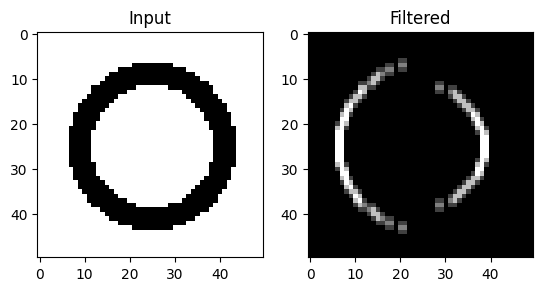

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.imread('kreis.png')
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_grey = img_grey.astype(np.float32)/255.


sobel_x_filter = np.array([[1, 0, -1], 
                   [2, 0, -2], 
                   [1, 0, -1]])

img_flt = cv2.filter2D(img_grey, -1, sobel_x_filter)

img_flt = img_flt * (img_flt > 0) # ReLu
img_flt = img_flt/np.max(img_flt) # Normierung 0-1 zur Anzeige

plt.subplot(1, 2, 1)
plt.imshow(img_grey, cmap=plt.get_cmap('gray'))
plt.title("Input")


plt.subplot(1, 2, 2)
plt.imshow(img_flt, cmap=plt.get_cmap('gray'))
plt.title("Filtered")

plt.show()

**Aufgabe 1.2 (CNN)** | Schreiben Sie den Code für die Funktion `max_pool_2d` mit NumPy Funktionen, die eine 2D MaxPooling Operation durchführt. Stride und Größe sollen dabei `(2,2)` betragen. Gehen Sie davon aus, dass die Dimensionen des Inputs `x` gerade sind.
```
Erwartete Ausgabe:
[[ 7  9 11]
 [19 21 23]
 [31 33 35]]
 ```

In [4]:
x = np.arange(36).reshape((6,6))

def max_pool_2d(x):
    a,b,c,d = x[::2,::2], x[1::2,::2], x[::2,1::2], x[1::2,1::2]
    e = np.stack([a,b,c,d], axis=-1)
    f= np.max(e, axis=-1)
    return f

print(x)
print(max_pool_2d(x))

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
[[ 7  9 11]
 [19 21 23]
 [31 33 35]]


## Aufgabe 2

**Aufgabe 2.0 (PyTorch)** | Zunächst ist wieder ein Datensatz vorgegeben. Zur späteren veranschaulichung kommt der normale MNIST Datensatz (Klassifikation Zahlen 0-9) zum Einsatz.

In [5]:
!pip install imshowtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 9912422/9912422 [00:00<00:00, 131920633.98it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 82630077.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75389888.23it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18695317.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([128, 1, 28, 28]) torch.Size([128, 10])


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


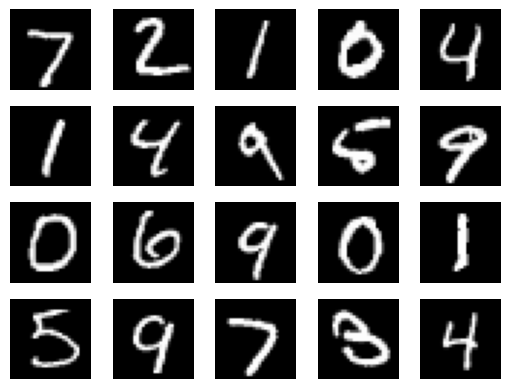

In [6]:
import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from imshowtools import imshow as multi_imshow

BATCH_SIZE = 128
BATCH_NORM = False
EPOCHS = 12
LEARNING_RATE = 0.001

trans_scale = transforms.Lambda(lambda x: x/255.) if BATCH_NORM else transforms.Normalize((0.5,), (0.5,))

transform = transforms.Compose([transforms.ToTensor(),
                                trans_scale, 
                                ])

transform_test = transforms.Compose([transforms.ToTensor(),
                                trans_scale,
                                ])

target_transform = transforms.Compose([transforms.Lambda(lambda x:torch.LongTensor([x])),
                                transforms.Lambda(lambda x: (F.one_hot(x, num_classes = 10).float().flatten(),x))
                                ])

# Trainingsdaten herunterladen + Transformation anwenden
train_set = datasets.MNIST('./data', download=True, train=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Testdaten herunterladen + Transformation anwenden
test_set = datasets.MNIST('./data', download=True, train=False, transform=transform_test, target_transform=target_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

data,(labels_one_hot,labels) = next(iter(test_loader))

print(data.size(),labels_one_hot.size())

scale_fn = lambda x: x*255 if BATCH_NORM else x/2 + 0.5

multi_imshow(*scale_fn(data[:20].resize(20,28,28,1))) 

**Aufgabe 2.1 (PyTorch)** | Erstellen Sie ein CNN Modell analog zum Video.
Unsere Bilder haben eine Eingangsgröße von `(28, 28, 1)` statt `(32, 32, 3)` wie im Video.

Verwenden Sie für die erste Schicht eine Filtergröße von `3` und ein Padding  von `1`. **(Optional)** Lesen Sie auch über [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) und bauen Sie diesen Layer nach jeder Faltung ein, bei der Verwendung können sie den Parameter `BATCH_NORM` auf `True` setzen.

Erwartete Genauigkeit auf den Testdaten: $98\%$



In [7]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 6, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    ) 

    self.conv2 = nn.Sequential(
      nn.Conv2d(6, 16, 5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )
    self.fc = nn.Sequential(
      nn.Linear(16 * 5 * 5, 120),
      nn.Linear(120, 84),
      nn.Linear(84, 10)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

# oder angepasstes Design
# BatchNorm kann das Training detulich beschleunigen
# ebenso hilft BatchNorm für ein stabileres Training, 
# indem durch Nomierung verhindert wird, dass
# Gewichte einzelner Layer zu groß oder klein werden
# 
class ModelCNN(nn.Module):
  def __init__(self):
    super(ModelCNN, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 32, 3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    ) 

    self.conv2 = nn.Sequential(
      nn.Conv2d(32, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, 3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2, 2),
    )

    self.fc = nn.Sequential(
      nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

**Aufgabe 2.2 (PyTorch)** | Der Trainingscode aus der letzten Übung ist gegeben. Hier können Sie auch ihren eigenen Code verwenden, zusammen mit dem vorher definierten Modell.

Wenn Sie mit der Advanced Übung weitermachen wollen, speichern Sie sich das erzeugte Modell ab:

```
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('YOUR_MODEL.pt') # Save
```


In [8]:
import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(12)
# Modell erstellen
model = ConvNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = nn.CrossEntropyLoss()

all_losses = []
progress_bar = tqdm.tqdm(range(EPOCHS), leave=False)

# Epochen durchlaufen
for epoch in progress_bar:
    losses_train = []
    
    total_train = 0
    model.train()
    # Modell trainieren
    for inputs_train, (target_train_oh, target_train) in train_loader:
        inputs_train = inputs_train.to(device)
        target_train_oh = target_train_oh.to(device)
        target_train = target_train.to(device)
        optimizer.zero_grad()
        y_train = model(inputs_train)
        loss = loss_fn(y_train, target_train_oh)

        loss.backward()
        
        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses_train.append(loss.item())
        total_train += target_train.size(0)

    # Modell testen
    with torch.no_grad():
        model.eval()
        correct_test = 0
        total_test = 0
        losses_test = []
        for inputs_test, (target_test_oh, target_test) in test_loader:
          inputs_test = inputs_test.to(device)
          target_test_oh = target_test_oh.to(device)
          target_test = target_test.to(device)
          y_test = model(inputs_test)
          _, target_pred = torch.max(y_test.data, 1)
          total_test += target_test.size(0)
          correct_test += (target_pred == target_test.flatten()).sum().item()
          loss_test = loss_fn(y_test, target_test_oh)

          losses_test.append(loss_test.item())

    epoch_loss = sum(losses_train) / total_train
    epoch_loss_test = sum(losses_test) / total_test
    acc_test = 100.0 * correct_test / total_test
    lr = optimizer.param_groups[-1]['lr']
    scheduler.step(epoch_loss_test)

    all_losses.append([epoch, epoch_loss, epoch_loss_test,acc_test,lr])


# Ergebnisse anzeigen
df_loss = pd.DataFrame(np.array(all_losses), columns=['epoch', 'loss_train', 'loss_test','acc_test','lr'])

fig = px.line(df_loss, x='epoch', y=['loss_train','loss_test'], width=850, height=500, log_y=True)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="loss",
)
fig.show()

fig = px.line(df_loss, x='epoch', y=['acc_test'], width=850, height=500)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="acc",
)
fig.show()

fig = px.line(df_loss, x='epoch', y=['lr'], width=850, height=500, log_y=True)
fig.update_layout(
    xaxis_title="epoch",
    yaxis_title="learning_rate",
)
fig.show()